## About Dataset
### Context
Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.

### Content
Columns

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance

### Acknowledgements
The dataset is available on GitHub here.

### Inspiration
Can you accurately predict insurance costs

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sn

In [111]:
df = pd.read_csv("../data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [112]:
len(df)

1338

In [113]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

Genders are evenly distributed

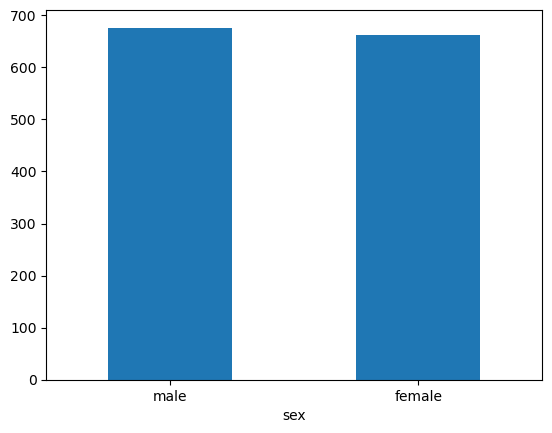

In [114]:
df.sex.value_counts().plot(kind="bar")
plt.xticks(rotation=0);

There are less smoking females than males.

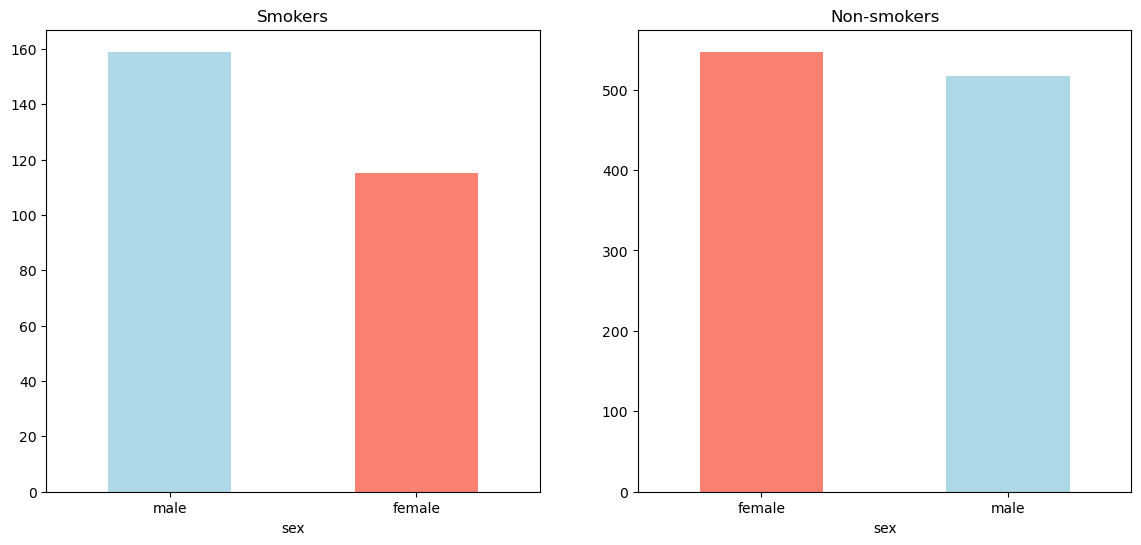

In [115]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
df.sex[df.smoker=="yes"].value_counts().plot(kind="bar", ax=ax1, title="Smokers", color=["lightblue", "salmon"])
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

df.sex[df.smoker=="no"].value_counts().plot(kind="bar", ax=ax2, title="Non-smokers", color=["salmon", "lightblue"])
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0);

Lets look at age and bmi

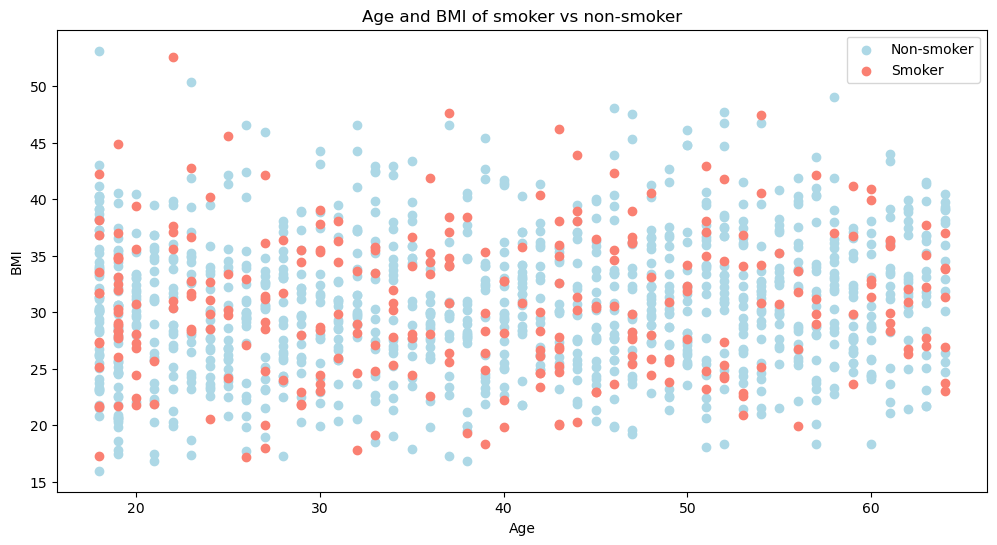

In [116]:
plt.figure(figsize=(12, 6))

plt.title("Age and BMI of smoker vs non-smoker")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.scatter(df.age[df.smoker=="no"], df.bmi[df.smoker=="no"], color="lightblue")
plt.scatter(df.age[df.smoker=="yes"], df.bmi[df.smoker=="yes"], color="salmon")

plt.legend(["Non-smoker", "Smoker"]);

What about smokers and charges compared to non smokers

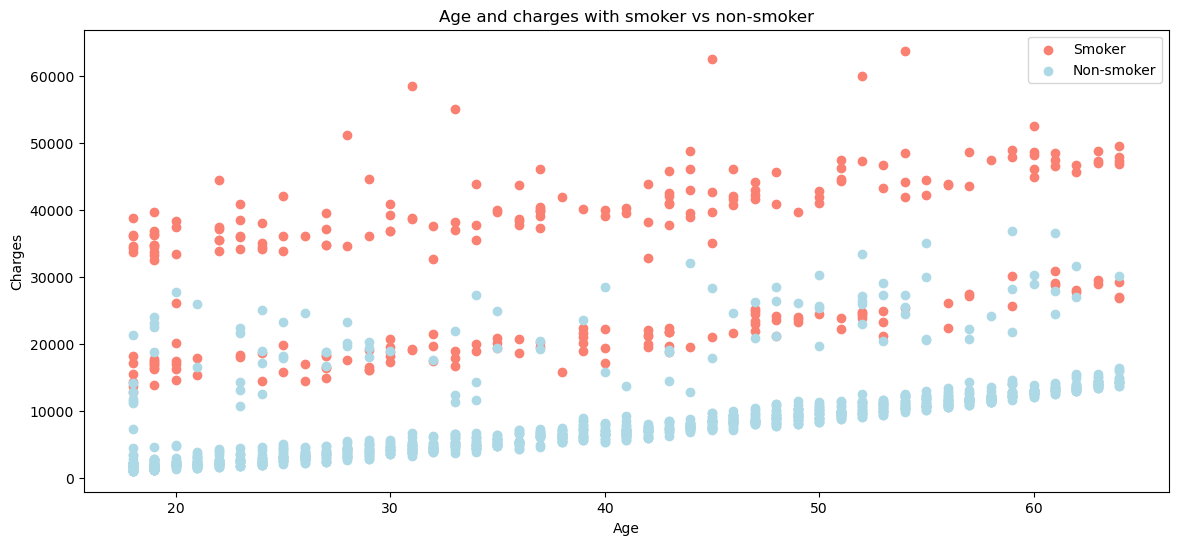

In [117]:
plt.figure(figsize=(14, 6))
plt.scatter(df.age[df.smoker=="yes"], df.charges[df.smoker=="yes"], color="salmon")
plt.scatter(df.age[df.smoker=="no"], df.charges[df.smoker=="no"], color="lightblue")

plt.xlabel("Age")
plt.ylabel("Charges")
plt.legend(["Smoker", "Non-smoker"])

plt.title("Age and charges with smoker vs non-smoker");

I can see that smokers get charged more.

Do you also get charged more if you have a higher bmi?

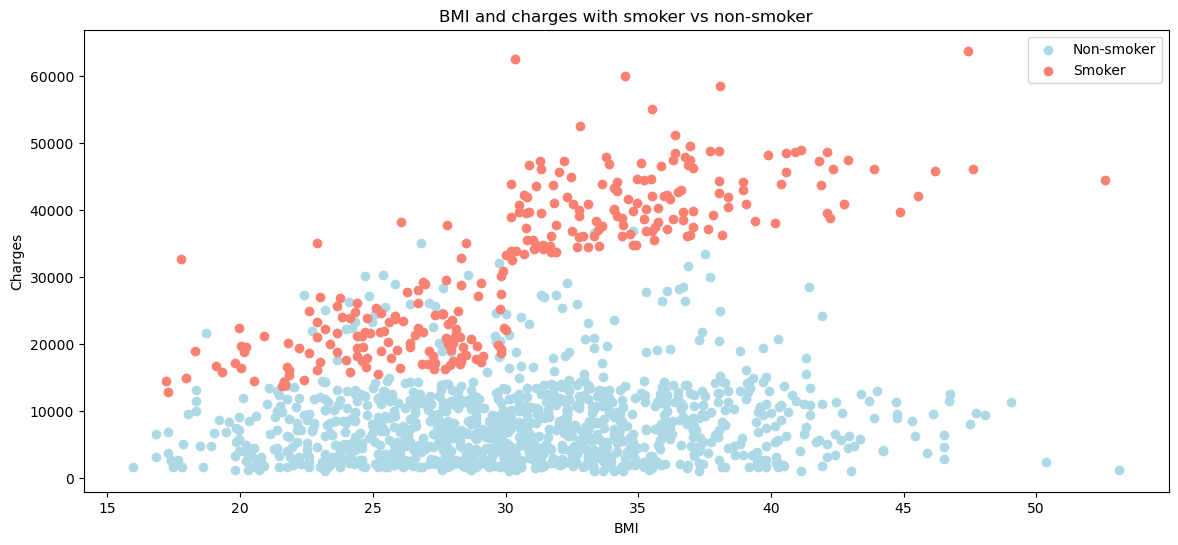

In [118]:
plt.figure(figsize=(14, 6))
plt.scatter(df.bmi[df.smoker=="no"], df.charges[df.smoker=="no"], color="lightblue")
plt.scatter(df.bmi[df.smoker=="yes"], df.charges[df.smoker=="yes"], color="salmon")

plt.legend(["Non-smoker", "Smoker"])
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("BMI and charges with smoker vs non-smoker");

In [119]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


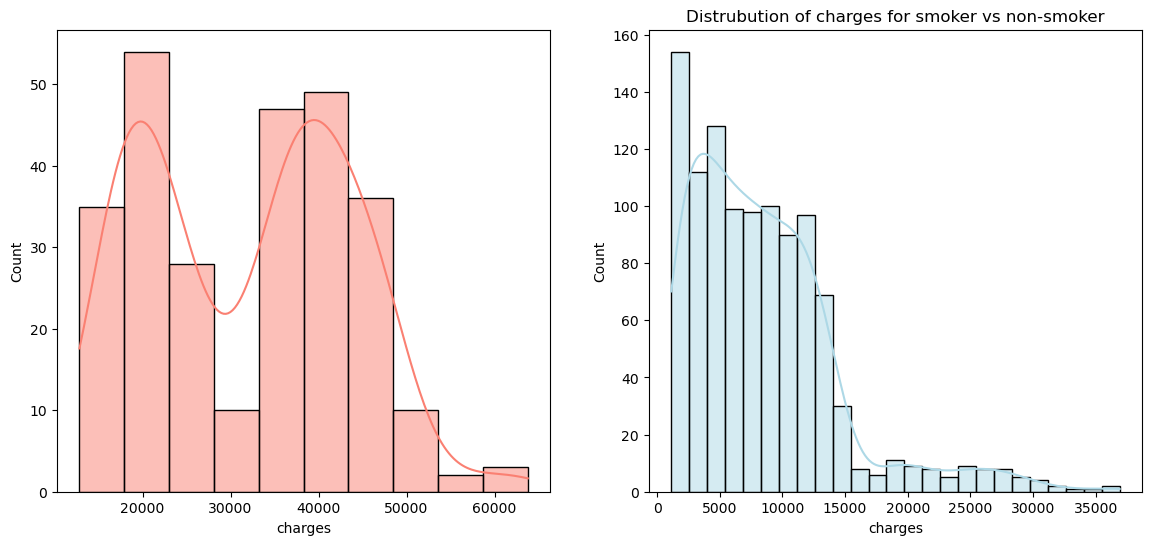

In [120]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sn.histplot(df.charges[df.smoker=="yes"], kde=True, color="salmon", ax=ax1);
plt.title("Distrubution of charges for smoker vs non-smoker")

sn.histplot(df.charges[df.smoker=="no"], kde=True, color="lightblue", ax=ax2);

In [12]:
encoder = LabelEncoder()

df["smoker"] = encoder.fit_transform(df["smoker"])
df["sex"] = encoder.fit_transform(df["sex"])
df["region"] = encoder.fit_transform(df["region"])

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


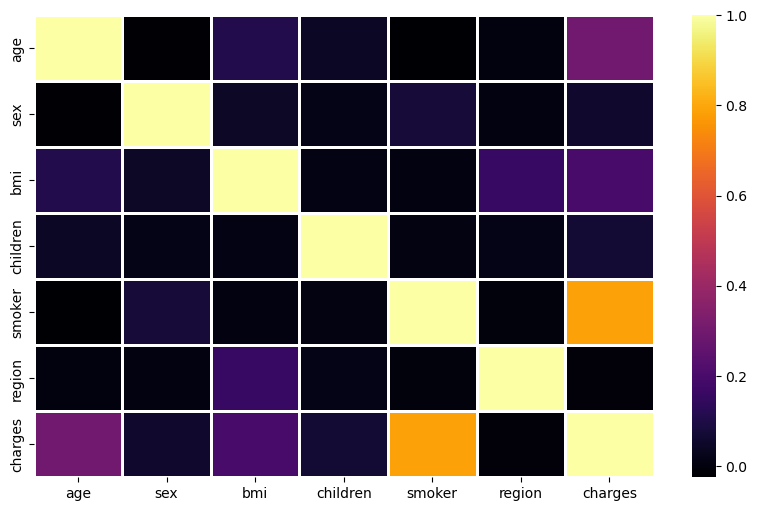

In [14]:
plt.figure(figsize=(10, 6))
sn.heatmap(df.corr(), linewidths=0.9, cmap="inferno");

The biggest correlation to charges is if the person is a smoker or not

In [15]:
X = df.drop("charges", axis=1)
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [81]:
regr = LinearRegression(n_jobs=-1).fit(X_train, y_train)
regr.score(X_test, y_test)

0.7061312515635358

Can I get the score better using GridSearchCV

In [17]:
hyperparameters = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, 1, -1]
}

gs_regr = GridSearchCV(regr, hyperparameters, n_jobs=-1, cv=5).fit(X_train, y_train)
gs_regr.best_params_

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [18]:
gs_regr.score(X_test, y_test)

0.7061312515635358

It  didn't make a difference so we can just stick to our normal regr

In [19]:
features_importance = dict(zip(df.columns, list(regr.coef_)))
features_importance

{'age': 249.22060134345017,
 'sex': -82.5399151754043,
 'bmi': 318.94130131022365,
 'children': 488.42440524406567,
 'smoker': 25010.76574525292,
 'region': -501.47574802277467}

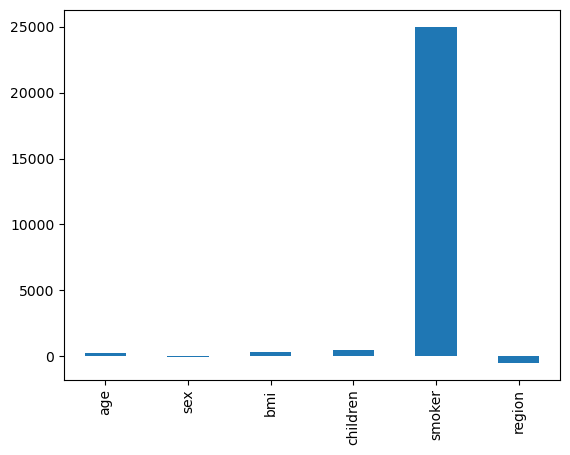

In [20]:
features_importance_df = pd.DataFrame(features_importance, index=[0])
features_importance_df.T.plot(kind="bar", legend=False);

* Most variables (age, sex, BMI, children, and region) have very low coefficients close to zero. This suggests they have minimal influence on the outcome.
* The “smoker” variable stands out with an extremely high coefficient, reaching up to 20,000. This indicates that being a smoker significantly impacts the predicted outcome.

Time for some metrics

In [21]:
y_preds = regr.predict(X_test)

In [22]:
scores = {
    "mae": mean_absolute_error(y_test, y_preds),
    "mse": mean_squared_error(y_test, y_preds),
    "rmse": mean_squared_error(y_test, y_preds, squared=False),
    "r2": r2_score(y_test, y_preds)
}

for name, score in scores.items():
    print(f"{name}: {score}")

mae: 4006.6409661823095
mse: 35799458.22822993
rmse: 5983.26484690674
r2: 0.7061312515635358


Let me see if I can get a better score using the RandomForestRegressor

In [23]:
# rf_regr = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
# rf_regr.score(X_test, y_test)

A much better score out the box. Let me see if I can get it better by tuning hyperparameters

In [24]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


In [25]:
# rs_rf_regr = RandomizedSearchCV(rf_regr, random_grid, n_jobs=-1, cv=5, n_iter=50).fit(X_train, y_train)
# rs_rf_regr.best_params_

In [26]:
# rs_rf_regr.score(X_test, y_test)

I'll use the rs_rf regressor 

In [82]:
rs_regr = RandomForestRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_depth=60, bootstrap=True).fit(X_train, 
                                                                                                                         y_train)
rs_regr.score(X_test, y_test)

0.8464330513679845

Feature importance of the regressor model

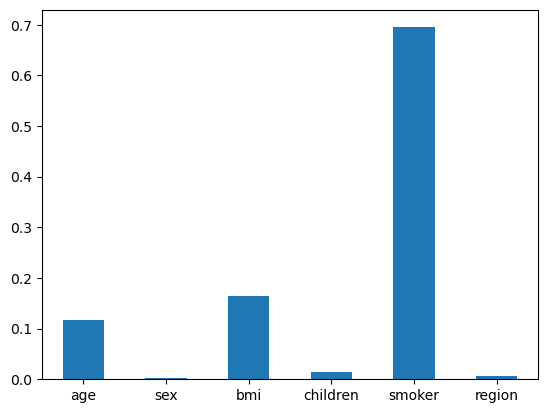

In [28]:
rf_features = dict(zip(df.columns, list(regr.feature_importances_)))
rf_features_df = pd.DataFrame(rf_features, index=[0])
rf_features_df.T.plot(kind="bar", legend=False)
plt.xticks(rotation=0);

I'm getting different coefficients using the RandomForestRegressor compared to LinearRegression

In [29]:
y_preds = regr.predict(X_test)
scores = {
    "mae": mean_absolute_error(y_test, y_preds),
    "mse": mean_squared_error(y_test, y_preds),
    "rmse": mean_squared_error(y_test, y_preds, squared=False),
    "r2": r2_score(y_test, y_preds)
}

for name, score in scores.items():
    print(f"{name}: {score}")

mae: 2323.9002628857634
mse: 18786322.09079243
rmse: 4334.3191034800875
r2: 0.8457878070291


Can i get the mean of charges for non smoker vs smokers?

In [30]:
df.charges[df.smoker==1].mean() - df.charges[df.smoker==0].mean()

23615.963533676637

It will be my first time trying XGBoost.

In [44]:
from xgboost import XGBRegressor

bst = XGBRegressor().fit(X_train, y_train)

In [45]:
bst.score(X_test, y_test)

0.7841931881240133

In [65]:
hyperparameters = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4],
    'booster': ['gbtree', 'gblinear'],
    'base_score': [0.25, 0.5, 0.75, 1]
}

In [66]:
rs_bst = RandomizedSearchCV(bst, hyperparameters, cv=5, n_jobs=-1, n_iter=100).fit(X_train, y_train)
rs_bst.best_params_

{'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 3,
 'learning_rate': 0.05,
 'booster': 'gbtree',
 'base_score': 0.75}

In [67]:
rs_bst.score(X_test, y_test)

0.8534841656198018

In [53]:
gs_hyperparameters = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.10, 0.12, 0.15, 0.20],
    'min_child_weight': [2],
    'booster': ['gbtree'],
    'base_score': [0.25, 0.30, 0.35, 0.20, 0.15]
}

gs_bst = GridSearchCV(bst, gs_hyperparameters, cv=5, n_jobs=-1).fit(X_train, y_train)
gs_bst.best_params_

{'base_score': 0.25,
 'booster': 'gbtree',
 'learning_rate': 0.12,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 100}

In [83]:
gs_bst.score(X_test, y_test)

0.8520042986022069

I'll stick to rs_bst

In [102]:
y_preds = rs_bst.predict(X_test)
rs_bst_scores = {
    "mae": mean_absolute_error(y_test, y_preds),
    "mse": mean_squared_error(y_test, y_preds),
    "rmse": mean_squared_error(y_test, y_preds, squared=False),
    "r2": r2_score(y_test, y_preds)
}

for name, score in scores.items():
    print(f"{name}: {score}")

mae: 2270.6791758283775
mse: 17826995.880651727
rmse: 4222.20272851171
r2: 0.8536626746016499


{'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 3,
 'learning_rate': 0.05,
 'booster': 'gbtree',
 'base_score': 0.75}

In [73]:
bst = XGBRegressor(n_estimators=100, min_child_weight=4, max_depth=3, learning_rate=0.05, base_score=0.75).fit(X_train, y_train)
bst.score(X_test, y_test)

0.8534841656198018

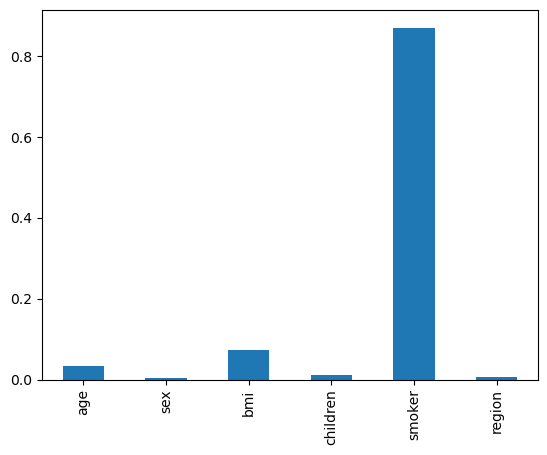

In [80]:
bst_features = dict(zip(df.columns, list(bst.feature_importances_)))
bst_features_df = pd.DataFrame(bst_features, index=[0])
bst_features_df.T.plot(kind="bar", legend=False);

XGBoostRegressor seems to have done the best job in this notebook. 

In [106]:
model_score = pd.DataFrame(data={"LinearRegression": regr.score(X_test, y_test),
                                "RandomForestRegressor": rs_regr.score(X_test, y_test),
                                "XGBoostRegressor": gs_bst.score(X_test, y_test)}, index=["Score"])

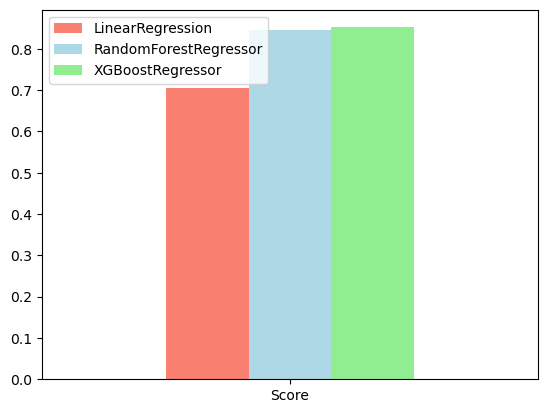

In [124]:
model_score.plot(kind="bar", color=["salmon", "lightblue", "lightgreen"])
plt.xticks(rotation=0);

In [109]:
rs_bst_scores

{'mae': 2256.0866244995727,
 'mse': 17848742.06793103,
 'rmse': 4224.777161925944,
 'r2': 0.8534841656198018}